In [1]:
import skimage.io as io
import matplotlib.pyplot as plt
import os
import numpy as np
import imageio
import seaborn as sns

import pandas as pd

# add the top level directory to allow it to be imported
import sys
sys.path.append(os.path.split(os.getcwd())[0])
from utilities import plotting_utilities
from utilities import helper_functions

# define the session we want to use as an example

In [2]:
sample_traces = pd.read_csv('sample_zscored_traces.csv')
sample_session_metrics = pd.read_csv('sample_session_metrics.csv')
accepted_cells = io.imread("sample_session_cell_images_accepted-cells-map.png")


# define the specific example cells. These were chosen to give a sense of the range of response types
cells_to_plot = [
    30,
    8,
    22,
    80,
    7,
    54,
    61,
    11,
    14,
    13,
    17,
    34,
    5,
    10,
    31
]
example_cells=['C{:0>3}'.format(C) for C in cells_to_plot]

# Individual plotting functions:

## show atlas images with schematized GRIN lens

In [3]:
def show_atlas_image(ax=None,aspect='coronal'):
    if ax is None:
        fig,ax=plt.subplots()
    image = imageio.imread('ApproximateLensLocation.png')
    
    if aspect == 'coronal':
        ax.imshow(image[:,100:1150])
    elif aspect == 'saggital':
        ax.imshow(image[:,1200:])
    elif aspect == 'both':
        ax.imshow(image[:,:])
    ax.axis('off')
    

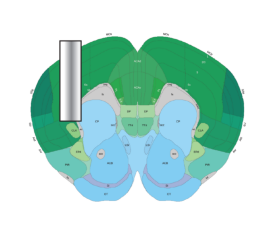

In [4]:
show_atlas_image(aspect='coronal')

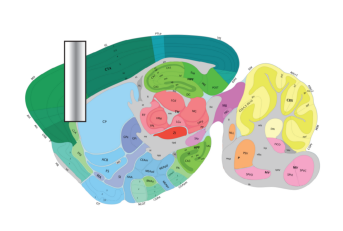

In [5]:
show_atlas_image(aspect='saggital')

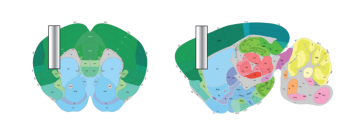

In [6]:
show_atlas_image(aspect='both')

## show the corresponding histology image

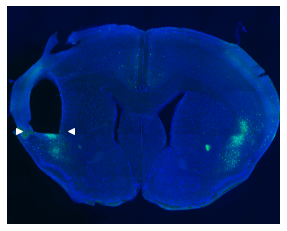

In [24]:
def show_histology_image(ax=None,R=1,G=1,B=1):
    '''
    set R, G, or B to less than 1 to increase contrast 
        e.g., G=0.5 sets the green channel ceiling at 0.5 times its default height
    '''
    if ax is None:
        fig,ax=plt.subplots()
    histology_image_path = "/olsenlab1/data/endoscope_imaging/Histology/M332849/M332849_slide1_section5_c1+2.jpg"
    histology_image = imageio.imread(histology_image_path)
    for CH, value in enumerate([R,G,B]):
        histology_image[:,:,CH] = histology_image[:,:,CH]/value
    histology_image[np.where(histology_image>255)] = 255
    ax.imshow(histology_image[:,750:6750])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
    # add arrows to denote lens location
    ax.plot(
        250,
        2750,
        '>',
        color='white'
    )
    ax.plot(
        1400,
        2750,
        '<',
        color='white'
    )
show_histology_image(G=0.5,B=0.4)

## show the full FOV with cells numbered

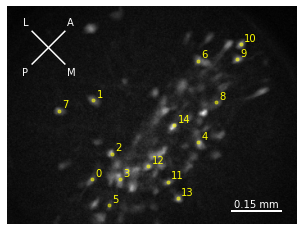

In [25]:
def plot_FOV(ax=None):
    if ax is None:
        fig,ax=plt.subplots()
    ax.imshow(accepted_cells)
    for ii,cell_id in enumerate(example_cells):
        row = sample_session_metrics.query('cellName == @cell_id')
        ax.plot(row['overallCenterInPixelsX'],row['overallCenterInPixelsY'],marker='.',color='yellow',alpha=0.5)
        ax.text(row['overallCenterInPixelsX']+4,row['overallCenterInPixelsY']-4,ii,color='yellow')

    ## add AP and ML direction axes
    ### these are approximate and based off of lens orientation in JD lab notes
    ax.plot([70,30],[30,70],color='white')
    ax.plot([30,70],[30,70],color='white')
    ax.text(25,25,'L',color='white',va='bottom',ha='right')
    ax.text(73,74,'M',color='white',va='top',ha='left')
    ax.text(73,25,'A',color='white',va='bottom',ha='left')
    ax.text(25,74,'P',color='white',va='top',ha='right')

    FOV_width = 0.9 # mm, approximate: https://www.inscopix.com/hubfs/2018%20nVista%20Specifications%20Sheet_GUI-MKT-003271_Rev%20A.pdf
    pixels_per_mm = np.shape(accepted_cells)[1]/FOV_width
    scale_bar_width = 0.15 #mm
    scale_bar_x = 275
    scale_bar_y = 250
    ax.plot(
        [scale_bar_x, scale_bar_x + scale_bar_width*pixels_per_mm],
        [scale_bar_y, scale_bar_y],
        linewidth=2,
        color='white'
    )
    scale_bar_text = '{} mm'.format(scale_bar_width)
    ax.text(
        scale_bar_x + 0.5*scale_bar_width*pixels_per_mm,
        scale_bar_y - 3,
        scale_bar_text,color='white',ha='center',va='bottom')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
plot_FOV()

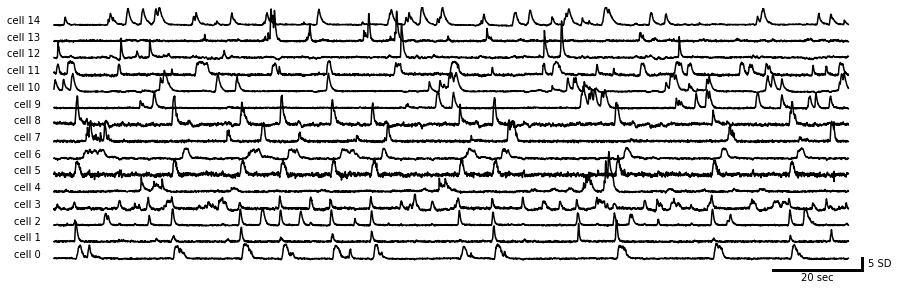

In [22]:
def plot_traces(ax=None,t0=13,t1=16):
    '''
    t0 and t1 are time limits in minutes
    '''
    x_scalebar_adjust = 0.05
    y_scalebar_adjust = 0.75
    SD_scale = 5
    time_scale = 20
    if ax is None:
        fig,ax=plt.subplots(figsize=(15,9))
    scale_factor = .15

    helper_functions.make_traces_plot(
        sample_traces[['t']+example_cells].query('t>=@t0*60 and t<=@t1*60'),
        colors=['black'],
        ax=ax,
        scale_factor=scale_factor
    )
    for ii in range(len(example_cells)):
        ax.text(t0-0.05,ii,'cell {}'.format(ii),ha='right')
    ax.set_xlim(t0-0.1,t1+x_scalebar_adjust+0.01)
    ax.set_ylim(-y_scalebar_adjust - 0.5 ,len(example_cells))
    ax.set_yticks(np.arange(15));
    xlims = ax.get_xlim()
    # horizontal scalebar
    ax.plot(
        [t1+x_scalebar_adjust,t1+x_scalebar_adjust],
        [0-y_scalebar_adjust,SD_scale*scale_factor-y_scalebar_adjust],
        color='black',
        linewidth=3
    )
    ax.text(
        t1+x_scalebar_adjust-time_scale/60/2,
        -y_scalebar_adjust-0.15, 
        '{} sec'.format(time_scale), 
        ha='center',
        va = 'top'
    )

    
    # vertical scalebar
    ax.plot(
        [t1+x_scalebar_adjust-time_scale/60,t1+x_scalebar_adjust],
        [0-y_scalebar_adjust,0-y_scalebar_adjust],
        color='black',
        linewidth=3
    )
    ax.text(
        t1+x_scalebar_adjust+0.025,
        0-y_scalebar_adjust+0.5*SD_scale*scale_factor, 
        '{} SD'.format(SD_scale), 
        ha='left',
        va = 'center'
    )
    ax.axis('off')

fig,ax = plt.subplots(figsize=(15,5))
plot_traces(ax)


# put it all together

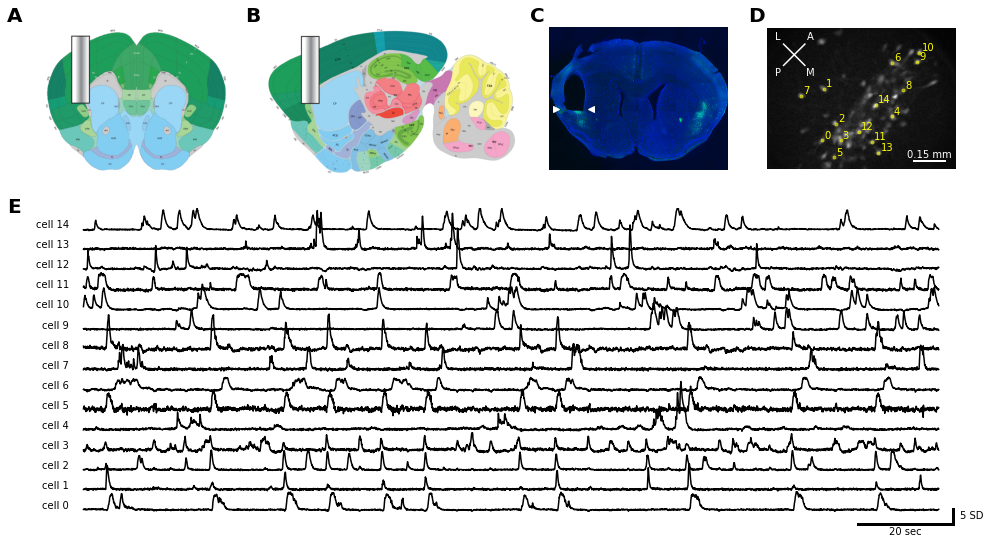

In [26]:
save_fig = True

figsize=(2*8.5,2*5)
figure_1 = plt.figure(figsize=figsize)
axes = {
    'AB':plotting_utilities.placeAxesOnGrid(figure_1, xspan=[0,0.55],yspan=[0,0.4]),
    'C':plotting_utilities.placeAxesOnGrid(figure_1, xspan=[0.58,0.76],yspan=[0,0.4]),
    'D':plotting_utilities.placeAxesOnGrid(figure_1, xspan=[0.8,1], yspan=[0,0.4]),
    'E':plotting_utilities.placeAxesOnGrid(figure_1, xspan=[0.05,1], yspan=[0.4,1]),
}
    
show_atlas_image(axes['AB'],aspect='both')
show_histology_image(axes['C'], G=0.5, B=0.4)
plot_FOV(axes['D'])
plot_traces(axes['E'])

# add labels
labels = [
    {'label_text':'A', 'xpos':0,    'ypos':0.05},
    {'label_text':'B', 'xpos':0.25, 'ypos':0.05},
    {'label_text':'C', 'xpos':0.55, 'ypos':0.05},
    {'label_text':'D', 'xpos':0.78, 'ypos':0.05},
    {'label_text':'E', 'xpos':0,    'ypos':0.40},
]
for label in labels:
    plotting_utilities.add_label(
        figure_1,
        label_text = label['label_text'],
        xpos = label['xpos'],
        ypos = label['ypos'],
        fontsize=20,
        weight="bold"
    )

if save_fig:
    plotting_utilities.save_figure(figure_1, fname='figure_1', formats=['.png','.pdf'],size=figsize, dpi=500)